Notebook for: GPR on the Hebeler CEFT EOS

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

import dickandballs as db
import helpers as hel

## Loading EOS:

In [2]:
ceft = np.loadtxt('EOS/ceft/ceft_hebeler.dat')
n, _, p_lower, e_lower, _,_,_,_,_,_,_,_, p_upper, e_upper, _, _, _ = ceft.T

p_avg = (p_upper+p_lower)/2
e_avg = (e_upper+e_lower)/2

p_width = p_upper-p_lower
e_width = e_upper-e_lower

cs2_avg = np.gradient(p_avg, e_avg) #dp/de


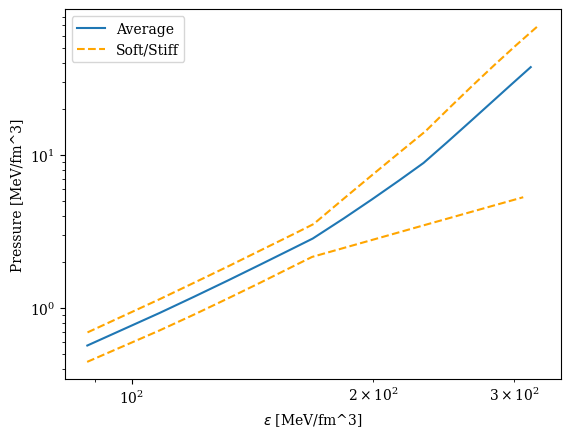

In [3]:
plt.rcParams["font.family"] = "serif"

plt.plot(e_avg, p_avg, label='Average')
plt.plot(e_lower, p_lower, '--', color='orange')
plt.plot(e_upper, p_upper, '--', color='orange', label='Soft/Stiff')
#plt.plot(e_avg+e_width/2, p_avg+p_width/2, color='red', label='Lower/Upper CI')
#plt.plot(e_avg-e_width/2, p_avg-p_width/2, color='red')
plt.ylabel('Pressure [MeV/fm^3]')
plt.xlabel(r'$\epsilon$ [MeV/fm^3]')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

# this looks like the hebeler paper fig 12 (truncated)

Error Propogation method is cancelled, c.f `classes.ipynb`

## Getting sound speed

In [4]:
cs2_lower = np.gradient(p_lower, e_lower) #dp/de
cs2_upper = np.gradient(p_upper, e_upper) #dp/de
cs2_crude_avg = (cs2_upper+cs2_lower)/2
cs2_crude_width = cs2_upper-cs2_lower
cs2_crude_sigma = hel.CI_to_sigma(cs2_crude_width)

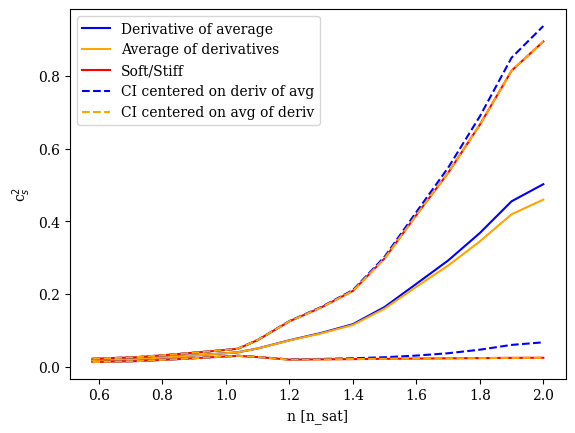

In [5]:
plt.plot(n, cs2_avg, color='blue', label='Derivative of average')
plt.plot(n, cs2_crude_avg, color='orange', label='Average of derivatives')


plt.plot(n, cs2_lower, color='red')
plt.plot(n, cs2_upper, color='red', label='Soft/Stiff')

plt.plot(n, cs2_avg+cs2_crude_width/2, '--', color='blue', label='CI centered on deriv of avg')
plt.plot(n, cs2_avg-cs2_crude_width/2, '--', color='blue')

plt.plot(n, cs2_crude_avg+cs2_crude_width/2, '--', color='orange', label='CI centered on avg of deriv')
plt.plot(n, cs2_crude_avg-cs2_crude_width/2, '--', color='orange')


plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()



unsure whether to use $\frac{dP_{avg}}{d\epsilon_{avg}}$ as $(c_s^2)_{avg}$ (derivative of averages)

or $\frac{(c_s^2)_{upper}+(c_s^2)_{lower}}{2}$ as $(c_s^2)_{avg}$ (average of derivatives)

for now use average of derivatives, in the code written with descriptor of 'crude' as when CI is centered on this, it overlaps with the bounds

## Getting phi:

Using average of get_phis for the same reason. We can justify this as keeping the band (soft to stiff EOS) until the very end and only getting the average to do the regression

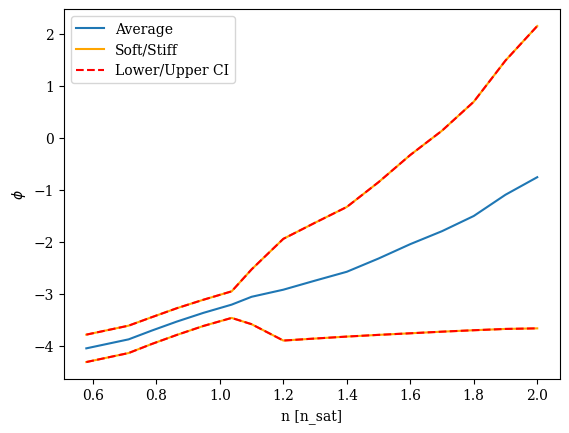

In [6]:
phi_lower = hel.get_phi(cs2_lower)
phi_upper = hel.get_phi(cs2_upper)
phi_width = phi_upper-phi_lower
phi_avg = (phi_upper+phi_lower)/2
phi_sigma = hel.CI_to_sigma(phi_width)

plt.plot(n, phi_avg, label='Average')
plt.plot(n, phi_lower, color='orange')
plt.plot(n, phi_upper, color='orange', label='Soft/Stiff')
plt.plot(n, phi_avg+phi_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n, phi_avg-phi_width/2, '--', color='red')
plt.ylabel(r'$\phi$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()


## Kernel

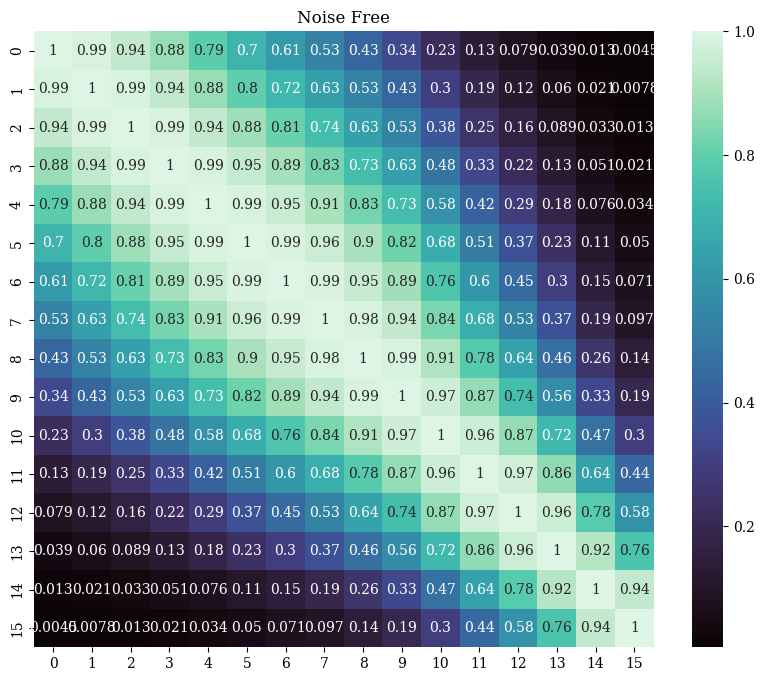

In [7]:
kern = db.Kernel('SE', sigma = 1, l = 1)
K11 = kern.compute(phi_avg)
kern.visualise_kernel(K11, title='Noise Free')

# Noise analysis

Constant Noise:

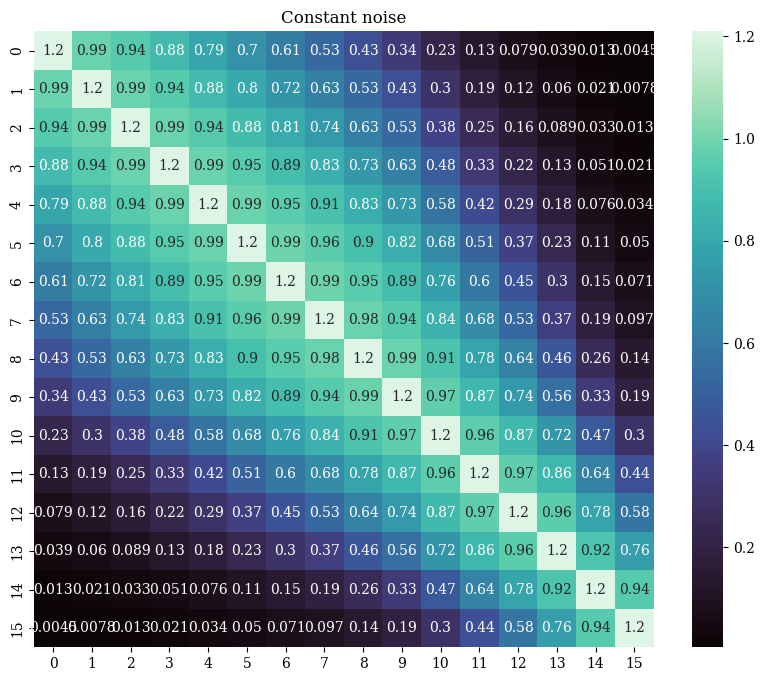

In [8]:
noiseconst_kern = K11 + np.eye(len(phi_sigma))*(phi_sigma[6]**2)
kern.visualise_kernel(noiseconst_kern, 'Constant noise')


## Naive diagonal noise addition

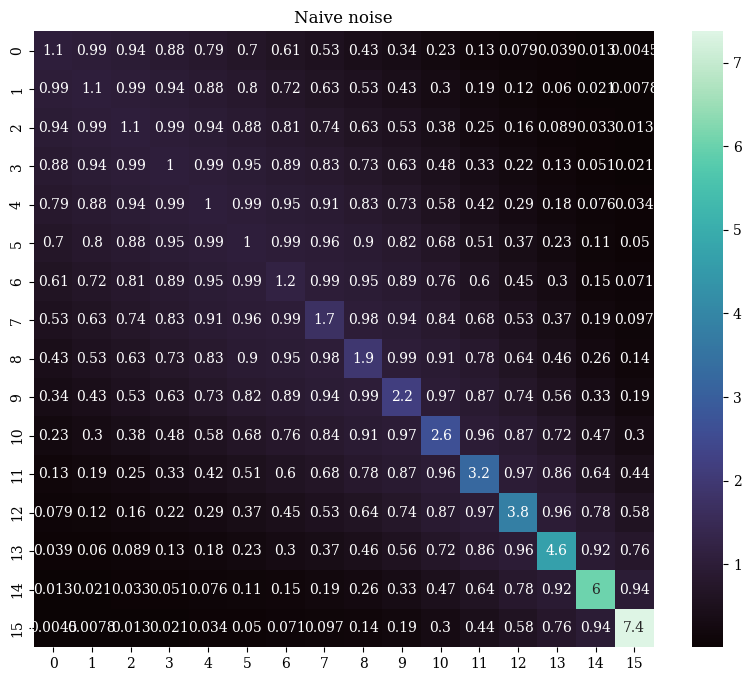

In [9]:
noise_kern = K11 + np.diag(phi_sigma**2)
kern.visualise_kernel(noise_kern, 'Naive noise')


## GPR on Naive Noise

In [10]:
n_crust = 0.07596

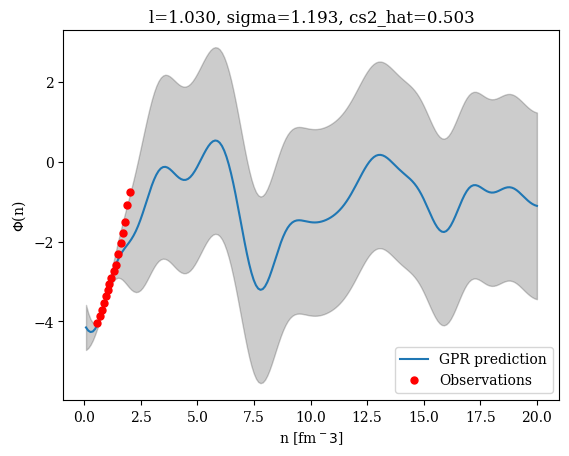

In [11]:
x_test = np.linspace(n_crust, 20, 200) # my number density, starting val is ending val of n crust

x_train = n
cs2_train = cs2_crude_avg

phi_train = phi_avg
train_noise = phi_sigma**2

cs2_hat, l_hat, nu_hat = hel.get_hype_samples()
kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
gp = db.GP(kernel, hel.get_phi(cs2_hat))

gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}")
plt.legend()
plt.show()

